In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)  # Crop to the desired output shape
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def test_step(self, data):
        x = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructed_x = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 88, 8)        32          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 44, 8)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 44, 16)       400         ['max_pooling1d[0][0]']          
                                                                                            

In [2]:
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(
                                    features, labels, test_size=0.2, random_state=42)

x_train_seq = x_train.values[:, 0]
x_test_seq = x_test.values[:, 0]

x_train_features = x_train.values[:, 1:]
x_test_features = x_test.values[:, 1:]

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [3]:
learn_rate = [0.005, 0.01, 0.05, 0.1]
batch_size = [32, 64, 128, 256]

param_grid = dict(learn_rate=learn_rate, batch_size=batch_size)

best_score = None
best_params = {}

for lr in learn_rate:
    for bs in batch_size:
        
        vae = VAE(encoder, decoder)
        vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

        vae.fit(x_train, batch_size=bs, epochs=10)

        score = vae.evaluate(x_test)

        if best_score is None or score < best_score:
            best_score = score
            best_params = {'learn_rate': lr, 'batch_size': bs}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

lr = best_params['learn_rate']
bs = best_params['batch_size']

Epoch 1/10
262/262 [==============================] - 3s 5ms/step - loss: 1.2174 - reconstruction_loss: 1.0595 - kl_loss: 0.0023
Epoch 2/10
262/262 [==============================] - 1s 5ms/step - loss: 0.9951 - reconstruction_loss: 0.9827 - kl_loss: 4.2141e-05
Epoch 3/10
262/262 [==============================] - 1s 6ms/step - loss: 0.9695 - reconstruction_loss: 0.9717 - kl_loss: 8.4115e-06
Epoch 4/10
262/262 [==============================] - 1s 6ms/step - loss: 0.9841 - reconstruction_loss: 0.9676 - kl_loss: 8.0508e-06
Epoch 5/10
262/262 [==============================] - 1s 6ms/step - loss: 0.9559 - reconstruction_loss: 0.9644 - kl_loss: 7.7698e-06
Epoch 6/10
262/262 [==============================] - 1s 5ms/step - loss: 0.9695 - reconstruction_loss: 0.9653 - kl_loss: 5.8151e-06
Epoch 7/10
262/262 [==============================] - 1s 5ms/step - loss: 0.9642 - reconstruction_loss: 0.9641 - kl_loss: 6.6819e-06
Epoch 8/10
262/262 [==============================] - 1s 5ms/step - loss:

131/131 [==============================] - 1s 8ms/step - loss: 0.9649 - reconstruction_loss: 0.9577 - kl_loss: 0.0000e+00
Epoch 9/10
131/131 [==============================] - 1s 8ms/step - loss: 0.9577 - reconstruction_loss: 0.9581 - kl_loss: 1.5060e-07
Epoch 10/10
66/66 [==============================] - 0s 2ms/step - total_loss: 0.9247 - reconstruction_loss: 0.9247 - kl_loss: 4.1723e-07
Epoch 1/10
66/66 [==============================] - 3s 13ms/step - loss: 0.9990 - reconstruction_loss: 0.9686 - kl_loss: 8.4223e-06
Epoch 2/10
66/66 [==============================] - 1s 13ms/step - loss: 0.9528 - reconstruction_loss: 0.9534 - kl_loss: 3.3803e-06
Epoch 3/10
66/66 [==============================] - 1s 13ms/step - loss: 0.9592 - reconstruction_loss: 0.9571 - kl_loss: 1.1515e-07
Epoch 4/10
66/66 [==============================] - 1s 13ms/step - loss: 0.9542 - reconstruction_loss: 0.9542 - kl_loss: 0.0000e+00
Epoch 5/10
66/66 [==============================] - 1s 13ms/step - loss: 0.9444

33/33 [==============================] - 1s 25ms/step - loss: 1.0208 - reconstruction_loss: 1.0169 - kl_loss: 3.6124e-09
Epoch 5/10
33/33 [==============================] - 1s 24ms/step - loss: 1.0083 - reconstruction_loss: 1.0138 - kl_loss: 7.9206e-05
Epoch 6/10
33/33 [==============================] - 1s 24ms/step - loss: 1.0049 - reconstruction_loss: 1.0138 - kl_loss: 9.9608e-05
Epoch 7/10
33/33 [==============================] - 1s 25ms/step - loss: 1.0099 - reconstruction_loss: 1.0107 - kl_loss: 2.9929e-06
Epoch 8/10
33/33 [==============================] - 1s 24ms/step - loss: 0.9993 - reconstruction_loss: 1.0069 - kl_loss: 9.2116e-08
Epoch 9/10
33/33 [==============================] - 1s 25ms/step - loss: 1.0073 - reconstruction_loss: 1.0043 - kl_loss: 0.0000e+00
Epoch 10/10
66/66 [==============================] - 0s 2ms/step - total_loss: 0.9527 - reconstruction_loss: 0.9527 - kl_loss: 0.0000e+00
Epoch 1/10
262/262 [==============================] - 3s 6ms/step - loss: 1.7492 

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)

vae.fit(x_train, batch_size=bs, epochs=50, validation_data=(x_test,),
        callbacks=[reduce_lr, early_stop])

Epoch 1/50
262/262 [==============================] - 4s 7ms/step - loss: 1.7974 - reconstruction_loss: 1.7923 - kl_loss: 8.9179e-08 - val_total_loss: 1.8315 - val_reconstruction_loss: 1.8315 - val_kl_loss: 0.0000e+00 - lr: 0.0050
Epoch 2/50
262/262 [==============================] - 2s 6ms/step - loss: 1.7849 - reconstruction_loss: 1.7917 - kl_loss: 0.0000e+00 - val_total_loss: 1.8313 - val_reconstruction_loss: 1.8313 - val_kl_loss: 0.0000e+00 - lr: 0.0050
Epoch 3/50
262/262 [==============================] - 2s 6ms/step - loss: 1.8033 - reconstruction_loss: 1.7915 - kl_loss: 0.0000e+00 - val_total_loss: 1.8315 - val_reconstruction_loss: 1.8315 - val_kl_loss: 0.0000e+00 - lr: 0.0050
Epoch 4/50
262/262 [==============================] - 2s 6ms/step - loss: 1.8090 - reconstruction_loss: 1.7916 - kl_loss: 3.1054e-08 - val_total_loss: 1.8326 - val_reconstruction_loss: 1.8326 - val_kl_loss: 0.0000e+00 - lr: 0.0050
Epoch 5/50
262/262 [==============================] - 2s 6ms/step - loss: 1.

In [5]:
#print(x_test.shape)
#print(y_test.shape)

validation_loss = vae.evaluate(x_test,)
print("Validation Loss:", validation_loss)


66/66 [==============================] - 0s 2ms/step - total_loss: 1.8310 - reconstruction_loss: 1.8310 - kl_loss: 0.0000e+00
Validation Loss: [1.8309745788574219, 1.8309745788574219, 0.0]


262/262 [==============================] - 0s 967us/step


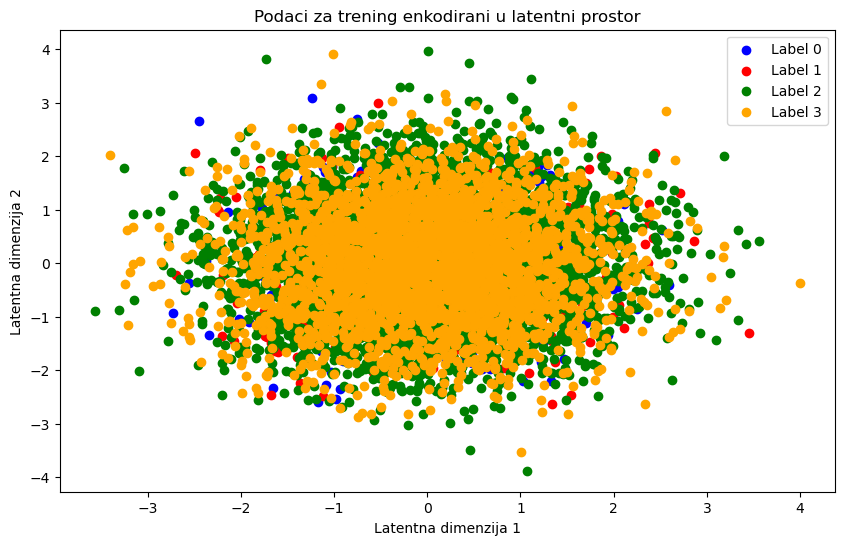

66/66 [==============================] - 0s 1ms/step


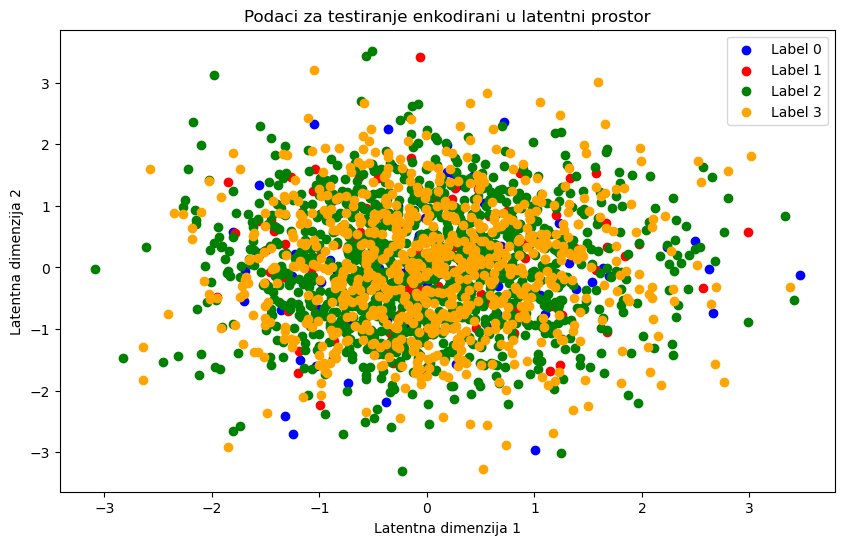

In [28]:
import matplotlib.pyplot as plt

def plot_input_data(x_data, y_data):
    _, _, z_input = encoder.predict(x_data)
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za trening enkodirani u latentni prostor")
plot_input_data(x_train, y_train)

plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(x_test, y_test)

262/262 [==============================] - 0s 937us/step


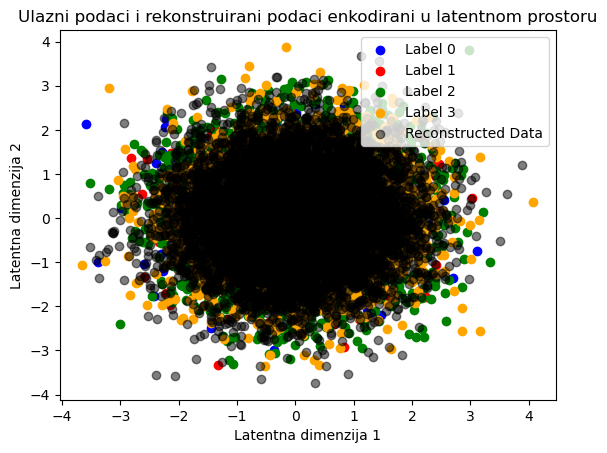

In [27]:
def plot_input_and_reconstructed_data(x_input_data, y_input_data):
    _, _, z_input = encoder.predict(x_input_data)
    reconstructed_data = vae.decoder.predict(z_input)
    _, _, recon_data_lsp = vae.encoder.predict(reconstructed_data)
    
    unique_labels = np.unique(y_input_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_input_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.scatter(recon_data_lsp[:, 0], recon_data_lsp[:, 1], c='black', alpha=0.5, label='Reconstructed Data')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title("Ulazni podaci i rekonstruirani podaci enkodirani u latentnom prostoru")
    plt.legend()
    plt.show()

plot_input_and_reconstructed_data(x_train, y_train)


262/262 [==============================] - 0s 939us/step


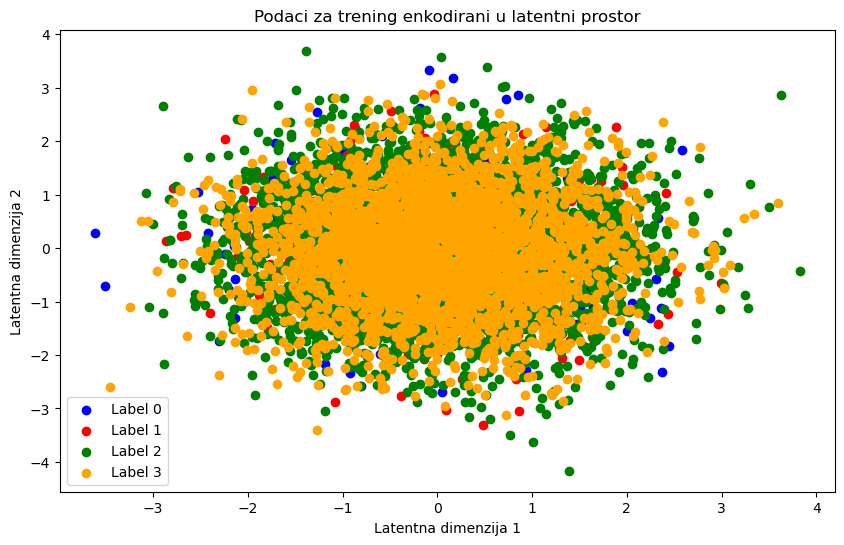

262/262 [==============================] - 0s 887us/step


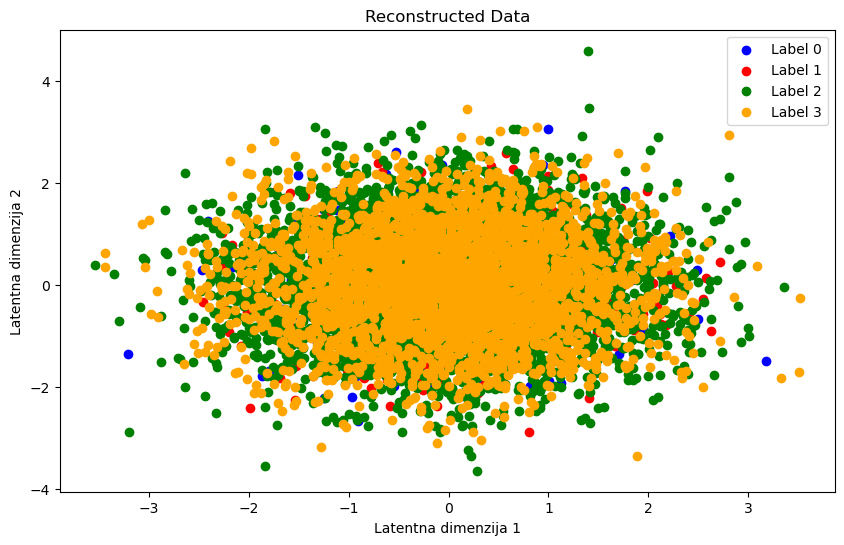

In [22]:
def plot_reconstructed_data(x_data, y_data):
    _, _, z = encoder.predict(x_data)
    reconstructed_data = decoder.predict(z)
    _, _, recon_data_lsp = encoder.predict(reconstructed_data)
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(recon_data_lsp[indices, 0], recon_data_lsp[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title("Reconstructed Data")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za trening enkodirani u latentni prostor")
plot_input_data(encoder, x_train, y_train)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirani podaci enkodirani u latentni prostor")
plot_reconstructed_data(x_train, y_train)

In [9]:
from Bio import pairwise2
from Bio.Seq import Seq

def calculate_sequence_similarity(seq1, seq2):
    # Convert the sequences to Seq objects
    seq1 = Seq(seq1)
    seq2 = Seq(seq2)

    # Perform global sequence alignment
    alignments = pairwise2.align.globalxx(seq1, seq2)

    # Get the alignment with the best score (the first one in the list)
    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned, score, begin, end = best_alignment

    # Calculate similarity as a percentage
    similarity = (score / max(len(seq1), len(seq2))) * 100

    return similarity

similarities_train = []
similarities_test = []

for i in range(50):
    row_similarities_train = []
    row_similarities_test = []
    for j in range(50,100):
        sim_train = calculate_sequence_similarity(x_train_seq[i], x_train_seq[j])/100
        sim_test = calculate_sequence_similarity(x_test_seq[i], x_test_seq[j])/100
        row_similarities_train.append(sim_train)
        row_similarities_test.append(sim_test)
        
    similarities_train.append(row_similarities_train)
    similarities_test.append(row_similarities_test)
    
similarities_train = np.array(similarities_train)
similarities_test = np.array(similarities_test)

print(similarities_train)
print(similarities_test)

[[0.25581395 0.13953488 0.39534884 ... 0.23255814 0.39534884 0.18604651]
 [0.1025641  0.         0.12820513 ... 0.04347826 0.13157895 0.125     ]
 [0.20512821 0.28       0.23076923 ... 0.24       0.18421053 0.32      ]
 ...
 [0.33333333 0.21621622 0.35897436 ... 0.24324324 0.34210526 0.32432432]
 [0.33333333 0.17777778 0.26666667 ... 0.2        0.33333333 0.22222222]
 [0.07692308 0.25       0.15384615 ... 0.2173913  0.18421053 0.16666667]]
[[0.27272727 0.18604651 0.27906977 ... 0.13953488 0.27906977 0.20930233]
 [0.36363636 0.25581395 0.27906977 ... 0.09302326 0.3255814  0.1627907 ]
 [0.25       0.17241379 0.26666667 ... 0.2        0.14285714 0.3       ]
 ...
 [0.15909091 0.31034483 0.33333333 ... 0.17857143 0.26190476 0.28571429]
 [0.34090909 0.2972973  0.54054054 ... 0.13513514 0.28571429 0.24324324]
 [0.09090909 0.13793103 0.06666667 ... 0.33333333 0.0952381  0.17647059]]


In [10]:
_, _, encoded_x_train_dist = vae.encoder.predict(x_train)
_, _, encoded_x_test_dist = vae.encoder.predict(x_test)

66/66 [==============================] - 0s 923us/step


In [11]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

def calculate_distance(latent_representations):
    num_peptides = len(latent_representations)
    distance_matrix = np.zeros((num_peptides, num_peptides))
    
    for i in range(num_peptides):
        for j in range(num_peptides):
            distance_matrix[i, j] = euclidean_distance(latent_representations[i], latent_representations[j])
    
    return distance_matrix

distances_train = []
distances_test = []

for i in range(50):
    row_distances_train = []
    row_distances_test = []
    for j in range(50,100):
        dist_train = euclidean_distance(encoded_x_train_dist[i], encoded_x_train_dist[j])
        dist_test = euclidean_distance(encoded_x_train_dist[i], encoded_x_test_dist[j])
        row_distances_train.append(dist_train)
        row_distances_test.append(dist_test)
        
    distances_train.append(row_distances_train)
    distances_test.append(row_distances_test)
        
distances_train = np.array(distances_train)
distances_test = np.array(distances_test)

normalized_distances_train = scaler.fit_transform(distances_train)
normalized_distances_test = scaler.fit_transform(distances_test)

print(normalized_distances_train)
print(normalized_distances_test)

[[0.11553709 0.76287556 0.44539705 ... 0.02163525 0.90938073 0.58322996]
 [0.5972495  0.30512556 0.40429756 ... 0.5878602  0.07701577 0.29419115]
 [0.59371096 1.         0.76230454 ... 0.5102161  0.9591546  0.3061429 ]
 ...
 [0.28218174 0.7091205  0.3573455  ... 0.21118267 0.75416857 0.371835  ]
 [0.6365411  0.065702   0.54484415 ... 0.6466548  0.19229586 0.5769162 ]
 [0.83330345 0.3098885  0.97114575 ... 0.85802054 0.6515337  0.9615949 ]]
[[0.2917156  0.94502425 0.7374478  ... 0.87762976 0.64194554 0.5617256 ]
 [0.49659827 0.15961288 0.2945845  ... 0.06656361 0.37210938 0.37104982]
 [0.6178781  1.         1.         ... 0.8352444  0.94880897 0.8917835 ]
 ...
 [0.23988332 0.8086325  0.66601884 ... 0.7065414  0.54262775 0.47279474]
 [0.63379115 0.03755854 0.20124212 ... 0.22249779 0.47629428 0.47793952]
 [0.98491865 0.3620094  0.5745021  ... 0.6175566  0.93936926 0.9307208 ]]


In [12]:
from scipy.stats import spearmanr, kendalltau, pearsonr

correlation_train, p_value_train = spearmanr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = spearmanr(similarities_test.flatten(), distances_test.flatten())

print("Spearman's Correlation:", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

correlation_train, p_value_train = pearsonr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = pearsonr(similarities_test.flatten(), distances_test.flatten())

print("Pearson's Correlation:", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

correlation_train, p_value_train = kendalltau(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = kendalltau(similarities_test.flatten(), distances_test.flatten())

print("Kendall's tau Correlation:", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

Spearman's Correlation: -0.0035668947937009575 -0.014918960144147543
p-value: 0.8585218428775228 0.45589914868604253
Pearson's Correlation: -0.0033833981520524498 -0.00493433872507151
p-value: 0.8657291642128477 0.8052216354347548
Kendall's tau Correlation: -0.002441542809661028 -0.009837655220287015
p-value: 0.8553760814434447 0.46300976011752104
